<a href="https://colab.research.google.com/github/tugce999/audio-classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf

In [ ]:
#This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [ ]:
def generate_features(y_cut):
    n_fft = 2048
    hop_length = 512
    max_size=200 #my max audio file feature width
    sr = 22050
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=255, hop_length = 512)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length,n_mfcc=128),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [ ]:
features = []
labels = []

def getFeaturesFromAllAudioFiles():
    
    SAMPLE_RATE = 22050
    PATH = r'data\\people\\'
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(PATH)):

        for f in filenames:
            # load audio file
            file_path = os.path.join(dirpath, f)
            signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
            
            image = generate_features(signal)
            features.append(image[np.newaxis,...])
            labels.append(i-1)
            
            noise_factor = 0.5 # Scale amaçlı kullanılır.
            noise = np.random.normal(0,signal.std(),signal.size) # Gaussian dist. kullanarak bir vektör oluşturuyoruz.
            augmented_signal = signal+ noise * noise_factor # signal ve noise ikiside bir vektör olduğu için ikisini topluyoruz.
            augmented_image =generate_features(augmented_signal)
            
            augmented_image = generate_features(augmented_signal)
            features.append(augmented_image[np.newaxis,...])
            #person_name = str(file_path).split('\\')[-2]
            labels.append(i-1)
            
    output=np.concatenate(features,axis=0)
    return (np.array(output), labels)
    
X,y = getFeaturesFromAllAudioFiles()
print(X.shape)

(286, 128, 200, 3)


In [ ]:
from keras.utils import to_categorical

y = to_categorical(y)

In [ ]:
y.shape

(286, 5)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
def normalizeArray(array):
    output = np.array((array-np.min(array))/(np.max(array)-np.min(array))/np.std(array))
    return output

In [ ]:
X_train = normalizeArray(X_train)
X_valid = normalizeArray(X_valid)


In [ ]:
input_shape=(128,200,3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(5, activation='softmax'))

In [ ]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_valid, y_valid))

Epoch 1/20
8/8 [==============================] - 17s 1s/step - loss: 1.6242 - accuracy: 0.2140 - val_loss: 1.6096 - val_accuracy: 0.1860
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: 1.6102 - accuracy: 0.1852 - val_loss: 1.6097 - val_accuracy: 0.2093
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 1.6097 - accuracy: 0.1975 - val_loss: 1.6095 - val_accuracy: 0.2093
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 1.6093 - accuracy: 0.1770 - val_loss: 1.6096 - val_accuracy: 0.2093
Epoch 5/20
8/8 [==============================] - 11s 1s/step - loss: 1.6110 - accuracy: 0.1975 - val_loss: 1.6104 - val_accuracy: 0.2093
Epoch 6/20
8/8 [==============================] - 11s 1s/step - loss: 1.6079 - accuracy: 0.1811 - val_loss: 1.6101 - val_accuracy: 0.1395
Epoch 7/20
8/8 [==============================] - 11s 1s/step - loss: 1.6081 - accuracy: 0.2222 - val_loss: 1.6107 - val_accuracy: 0.1395
Epoch 8/20
8/8 [==================

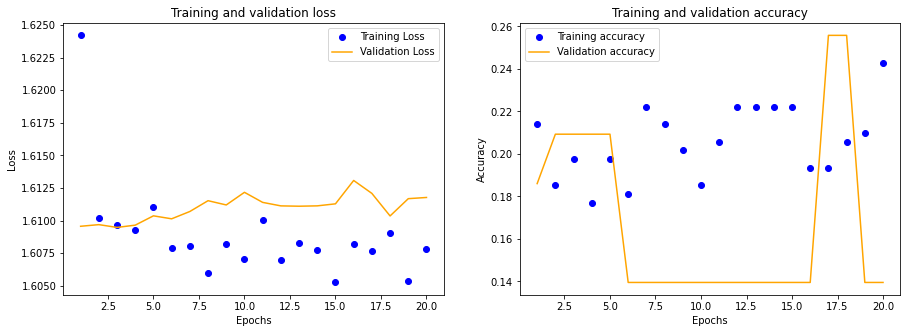

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
def plot_history(history):
    history_dict=history.history
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values=history_dict['val_accuracy']
    epochs=range(1,21)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    ax1.plot(epochs,loss_values,'bo',label='Training Loss')
    ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
    ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()
plot_history(history)

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50


model = ResNet50(include_top=False,input_shape=(128,1000,3))
for layer in model.layers :
    layer.trainable = False
flat1 = keras.layers.Flatten()(model.layers[-1].output)
class1 = keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
class1 = keras.layers.Dropout(0.25)(class1)
class1 = keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(class1)
class1 = keras.layers.Dropout(0.25)(class1)
output = keras.layers.Dense(5, activation='softmax')(class1)
model = keras.Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,                    
                    validation_data= (X_valid,y_valid),
                    verbose='auto',
                    epochs=10,batch_size=32
                    )

Epoch 1/10
4/4 [==============================] - 44s 10s/step - loss: 33.4797 - accuracy: 0.1682 - val_loss: 21.6149 - val_accuracy: 0.1667
Epoch 2/10
4/4 [==============================] - 33s 9s/step - loss: 31.1930 - accuracy: 0.2056 - val_loss: 12.7198 - val_accuracy: 0.2778
Epoch 3/10
4/4 [==============================] - 33s 9s/step - loss: 23.9164 - accuracy: 0.1963 - val_loss: 6.8822 - val_accuracy: 0.1389
Epoch 4/10
4/4 [==============================] - 33s 8s/step - loss: 18.1360 - accuracy: 0.1682 - val_loss: 7.5050 - val_accuracy: 0.2222
Epoch 5/10
4/4 [==============================] - 32s 8s/step - loss: 12.5890 - accuracy: 0.2056 - val_loss: 9.4684 - val_accuracy: 0.1667
Epoch 6/10
4/4 [==============================] - 33s 8s/step - loss: 11.2359 - accuracy: 0.1495 - val_loss: 3.5260 - val_accuracy: 0.1389
Epoch 7/10
4/4 [==============================] - 32s 8s/step - loss: 6.9740 - accuracy: 0.1963 - val_loss: 3.5068 - val_accuracy: 0.2222
Epoch 8/10
4/4 [=========

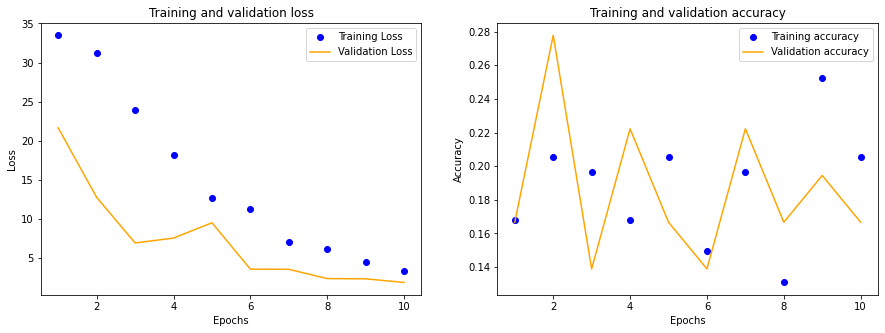

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,11)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50


model = ResNet50(include_top=False,input_shape=(128,1000,3),weights='imagenet')
flat1 = keras.layers.Flatten()(model.layers[-1].output)
class1 = keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
class1 = keras.layers.Dropout(0.25)(class1)
class1 = keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(class1)
class1 = keras.layers.Dropout(0.25)(class1)
output = keras.layers.Dense(5, activation='softmax')(class1)
model = keras.Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,                    
                    validation_data= (X_valid,y_valid),
                    verbose='auto',
                    epochs=10,batch_size=1
                    )

Epoch 1/10
121/121 [==============================] - 232s 2s/step - loss: 6.0529 - accuracy: 0.1818 - val_loss: 1.6101 - val_accuracy: 0.2273
Epoch 2/10
121/121 [==============================] - 224s 2s/step - loss: 1.7973 - accuracy: 0.1653 - val_loss: 1.6075 - val_accuracy: 0.3636
Epoch 3/10
121/121 [==============================] - 222s 2s/step - loss: 1.8524 - accuracy: 0.2397 - val_loss: 1.6091 - val_accuracy: 0.3636
Epoch 4/10
121/121 [==============================] - 269s 2s/step - loss: 1.8130 - accuracy: 0.1653 - val_loss: 1.6057 - val_accuracy: 0.3636
Epoch 5/10
121/121 [==============================] - 269s 2s/step - loss: 1.8171 - accuracy: 0.1736 - val_loss: 1.6034 - val_accuracy: 0.3636
Epoch 6/10
121/121 [==============================] - 274s 2s/step - loss: 1.6377 - accuracy: 0.2397 - val_loss: 1.6061 - val_accuracy: 0.3636
Epoch 7/10
121/121 [==============================] - 268s 2s/step - loss: 1.6097 - accuracy: 0.2562 - val_loss: 1.6141 - val_accuracy: 0.0455

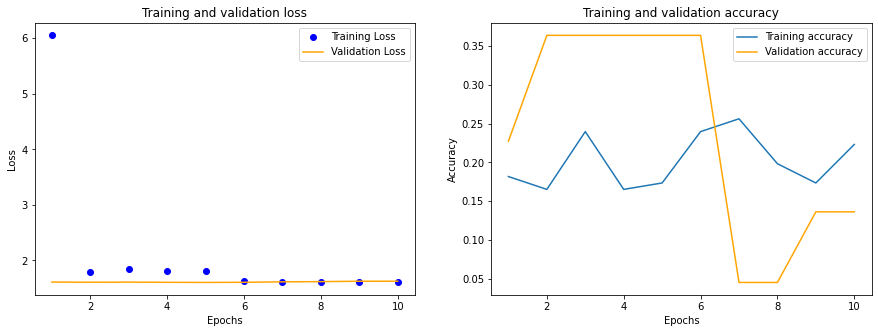

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,11)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values, label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()